# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
import json
from datasets import load_dataset, DatasetDict
from transformers import T5Tokenizer, DataCollatorForSeq2Seq, T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report 
from datasets import load_dataset, DatasetDict, ClassLabel
import time

# Display Versions

In [2]:
!python --version

Python 3.10.12


In [3]:
import transformers
print(transformers.__version__)

4.47.0


In [4]:
print(torch.__version__)

2.5.1+cu121


In [5]:
!pip list | grep sentencepiece

sentencepiece                      0.2.0


# Define Variables

In [6]:
# Define Dictionary mapping numerical labels to string labels for screening test response
SCREENING_TEST_RESPONSES = {
    0:"This patient's screening results indicate a low risk of cardiovascular disease.", 
    1:"This patient's screening results indicate an elevated risk of cardiovascular disease."
}

In [7]:
PROMPT_QUESTION = "What is the screening result for this patient's cardiovascular disease risk?"

# Define Functions

In [8]:
def annotated_countplot(data, x, hue=None, palette=None, figsize=(10, 6),
                        title=None, xlabel=None, ylabel=None, legend_labels=None,
                        legend_title=None, annotate=False, annotation_format='.2f',
                        annotation_offset=5, adjust_params=None):
    """
    Create a count plot with optional annotations and subplot adjustments.

    Parameters:
    - data: DataFrame containing the data.
    - x: Column name for the x-axis.
    - hue: Column name for color grouping (optional).
    - palette: Color palette for the plot (optional).
    - figsize: Tuple specifying the figure size (default is (10, 6)).
    - title: Title of the plot (optional).
    - xlabel: Label for the x-axis (optional).
    - ylabel: Label for the y-axis (optional).
    - legend_labels: List of labels for the legend (optional).
    - legend_title: Title for the legend (optional).
    - annotate: Boolean to indicate whether to annotate bars (default is False).
    - annotation_format: String format for annotations (default is '.2f').
    - annotation_offset: Offset for annotations above bars (default is 5).
    - adjust_params: Dictionary for subplot adjustments (optional).
    """

    # Create the count plot
    plt.figure(figsize=figsize)
    ax = sns.countplot(data=data, x=x, hue=hue, palette=palette)

    # Add count labels on top of the bars
    if annotate:
        for p in ax.patches:
            ax.annotate(
                format(p.get_height(), annotation_format),  # Format the count
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position at the top of the bar
                ha='center', va='center',       # Center alignment
                xytext=(0, annotation_offset),  # Offset the text
                textcoords='offset points'      # Interpret `xytext` as offset in points
            )

    # Set plot title and labels
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    # Set legend labels and title
    if legend_labels or legend_title:
        legend = plt.legend()
        if legend_labels:
            for t, l in zip(legend.texts, legend_labels):
                t.set_text(l)
        if legend_title is not None:
            legend.set_title(legend_title)

    # Adjust the subplot parameters to add space around the plot
    if adjust_params:
        plt.subplots_adjust(**adjust_params)

    # Show the plot
    plt.show()

In [9]:
def create_boxplot(data, x, y, palette='coolwarm', figsize=(6, 4),
                   title=None, xlabel=None, ylabel=None):
    """
    Create a box plot with the given parameters.

    Parameters:
    - data: DataFrame containing the data.
    - x: Column name for the x-axis (categorical variable).
    - y: Column name for the y-axis (numeric variable).
    - palette: Color palette for the plot (default is 'coolwarm').
    - figsize: Tuple specifying the figure size (default is (6, 4)).
    - title: Title of the plot (optional).
    - xlabel: Label for the x-axis (optional).
    - ylabel: Label for the y-axis (optional).
    """
    # Create the box plot
    plt.figure(figsize=figsize)
    ax = sns.boxplot(data=data, x=x, y=y, palette=palette)

    # Set plot title and labels
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    # Show the plot
    plt.show()

In [10]:
def cramers_v(confusion_matrix):
    """
    Calculates Cramer's V, a measure of association between two nominal variables.

    Cramer's V quantifies the strength of the relationship between two categorical variables,
    based on the chi-squared statistic. It ranges from 0 to 1, where 0 indicates no association
    and 1 indicates a perfect association.

    Args:
        confusion_matrix (pandas.DataFrame or numpy.ndarray): A contingency table
            representing the relationship between two categorical variables.
            If it's a pandas DataFrame, it should have row and column names.

    Returns:
        float: Cramer's V value.
    """

    # Calculate chi-squared statistic
    chi2 = chi2_contingency(confusion_matrix)[0]

    # Calculate total number of observations
    n = confusion_matrix.values.sum()

    # Calculate Cramer's V
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

In [11]:
def compute_associations(df, target):
    """
    Computes associations between each column in a DataFrame and a target variable.

    For numerical columns, it calculates the absolute Point-Biserial correlation.
    For categorical columns, it calculates Cramer's V.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        target (str): The name of the target variable column.

    Returns:
        pandas.DataFrame: A DataFrame containing the association scores for each column,
                          indexed by column name and with a single column 'Association'.
    """

    # Initialize an empty dictionary to store associations
    associations = {}
    for column in df.columns:
        
        if column == target:
            continue  # Skip the target column itself
            
        if pd.api.types.is_numeric_dtype(df[column]):
            # Compute Point-Biserial correlation for numerical features
            corr, _ = pointbiserialr(df[column], df[target]) # Calculate Point-Biserial correlation
            associations[column] = abs(corr)  # Use absolute value for association strength
            
        else:
            # Compute Cramér's V for categorical features
            contingency_table = pd.crosstab(df[column], df[target]) # Create contingency table
            associations[column] = cramers_v(contingency_table) # Calculate Cramer's V
    return pd.DataFrame.from_dict(associations, orient='index', columns=['Association']) # Return results as dataframe

In [12]:
def analyze_risk_distribution(screening_data, dataset_partition="Full Dataset"):
    """
    Calculates and prints the distribution of cardiovascular risk levels in a dataset,
    displaying the original string labels.

    Args:
        screening_data (list or Dataset object): The dataset containing cardiovascular risk levels.
        dataset_partition (str, optional): The name of the dataset partition. Defaults to "Full Dataset".
    """
    risk_levels = [record['response'] for record in screening_data]
    risk_level_counts = {}
    for risk_level in risk_levels:
        risk_level_counts[risk_level] = risk_level_counts.get(risk_level, 0) + 1
    total = len(risk_levels)
    risk_level_distribution = {risk_level: count / total for risk_level, count in risk_level_counts.items()}
    print(f"\nDistribution in {dataset_partition} (before splitting):" if dataset_partition == "Full Dataset" else f"\nDistribution in {dataset_partition} set:")

    for risk_level, proportion in risk_level_distribution.items():
        original_label = SCREENING_TEST_RESPONSES.get(risk_level)
        print(f"- {original_label}: {proportion:.4f}")

In [13]:
def prepare_patient_case_cvd_status_json(patient_data):

    """
    Prepares a patient case JSON string for cardiovascular disease risk screening.

    Args:
        patient_data (dict): Dictionary containing patient data.

    Returns:
        str: JSON string representing the patient case and risk screening result.
    """

    gender = 'female' if patient_data['gender'] == 1 else 'male'
    pronouns = ('She', 'Her') if patient_data['gender'] == 1 else ('He', 'His')
    
    cholesterol = {1: 'normal', 2: 'above normal', 3: 'well above normal'}.get(patient_data['cholesterol'])

    gluc = {1: 'normal', 2: 'above normal', 3: 'well above normal'}.get(patient_data['gluc'])

    smoke = 'smokes' if patient_data['smoke'] == 1 else 'does not smoke'

    alco = 'consumes alcohol' if patient_data['alco'] == 1 else 'does not consume alcohol'

    active = 'is physically active' if patient_data['active'] == 1 else 'is not physically active'

    cardio = SCREENING_TEST_RESPONSES.get(1) if patient_data['cardio'] == 1 else SCREENING_TEST_RESPONSES.get(0)

    patient_case = f"A {patient_data['age']}-year-old {gender} with a height of {patient_data['height']} cm and weight of {patient_data['weight']} kg has a systolic blood pressure of {patient_data['ap_hi']} mm Hg and diastolic blood pressure of {patient_data['ap_lo']} mm Hg. {pronouns[1]} cholesterol level is {cholesterol}, and glucose is {gluc}. {pronouns[0]} {smoke}, {alco}, and {active}."

    prompt = f"{patient_case} What is the screening result for this patient's cardiovascular disease risk?"

    patient_case_cvd_status = {'prompt':prompt,'response':cardio}

    return json.dumps(patient_case_cvd_status)

In [14]:
def compute_exact_match_validation_accuracy(eval_pred):
    """
    Computes exact match validation accuracy for text generation predictions.

    Args:
        eval_pred (EvalPrediction): A named tuple containing predictions and labels.

    Returns:
        dict: A dictionary containing the exact match accuracy.
    """
    start_time = time.time()  # Record start time of evaluation
    
    predictions, labels = eval_pred # Unpack predictions and labels from eval_pred

    # Decode token IDs back into text, skipping special tokens
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Initialize a counter for exact matches
    exact_matches = 0

    # Iterate through predictions and labels to check for exact matches
    for pred, label in zip(decoded_predictions, decoded_labels):
        # Check if the predicted text exactly matches the label text
        if(pred == label): 
            exact_matches += 1

    # Calculate the accuracy as the proportion of exact matches
    accuracy = exact_matches / len(decoded_predictions)

    # Record end time of evaluation
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Print the elapsed time for evaluation
    print(f"\nExact Match Validation Accuracy computed in {elapsed_time:.2f} seconds")

    # Return the accuracy as a dictionary
    return {"exact_match_validation_accuracy": accuracy}

In [15]:
# Tokenize Patient Cases
def tokenize_patient_cases(batch):
    """
    Tokenizes patient case prompts and responses for cardiovascular disease risk screening.

    Args:
        batch (dict): A batch of patient case data, including 'prompt' and 'response'.

    Returns:
        dict: A dictionary containing tokenized inputs and labels.
    """
    
    # Tokenize the patient case prompts
    tokenized_prompts = tokenizer(batch['prompt'], max_length=512, truncation=True, padding='max_length')

    # Convert integer labels to string labels
    string_responses = [label_feature.int2str(label_id) for label_id in batch['response']]
    
    # Tokenize the string responses (labels)
    tokenized_responses = tokenizer(string_responses, max_length=512, truncation=True, padding='max_length')
    
    # Prepare the labels for the model
    tokenized_prompts['labels'] = tokenized_responses['input_ids']

    return tokenized_prompts

In [16]:
def create_reverse_mapping(mapping):
    return {value: key for key, value in mapping.items()}

In [17]:
def get_response(query: str):

    # Append question to query
    prompt = f"{query} {PROMPT_QUESTION}"
    
    # Tokenize user query
    tokenized_query = tokenizer(prompt, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

    # Move tensors to device
    input_ids = tokenized_query['input_ids'].to(device)
    attention_mask = tokenized_query['attention_mask'].to(device)

    with torch.no_grad():  # Disable gradient calculations during inference
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=150,  # Adjust the maximum length of the generated output
            num_beams=4,  # For beam search (improves quality but is slower)
            early_stopping=True,
        )

    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return decoded_output

# Preprocess Dataset

In [18]:
# Confirm CSV File (Dataset) Path
!ls -lrt /kaggle/input

total 2876
-rw-r--r-- 1 nobody nogroup 2941524 Feb 18 15:08 cardio_train.csv


In [19]:
# Load CSV File in Dataframe
df = pd.read_csv("/kaggle/input/cardio_train.csv", sep=";")

In [20]:
# Check top 5 rows in dataframe
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Features
- **`id`**: Unique Identification Number assigned to each patient
- **`age`**: Age of the patient, expressed in days
- **`gender`**: Patient's gender, represented numerically:
  * 1: Female
  * 2: Male
- **`height`**: Patient's height, measured in centimeters (cm)
- **`weight`**: Patient's weight in kilograms (kg)
- **`ap_hi`**: Systolic Blood Pressure, measured in millimeters of mercury (mm Hg)
- **`ap_lo`**: Diastolic Blood Pressure, measured in millimeters of mercury (mm Hg)
- **`cholesterol`**: Patient's cholesterol level, categorized as:
  * 1: Normal
  * 2: Above Normal
  * 3: Well Above Normal
- **`gluc`**: Patient's glucose level, categorized as:
  * 1: Normal
  * 2: Above Normal
  * 3: Well Above Normal
- **`smoke`**: Indicates whether the patient is a smoker (Binary: 0-No/1-Yes)
- **`alco`**: Indicates whether the patient consumes alcohol (Binary: 0-No/1-Yes)
- **`active`**: Indicates whether the patient engages in regular physical activity (Binary: 0-No/1-Yes)

<br>

Target
 - **`cardio`**: Indicates risk of cardiovascular disease (Binary: 0-Low/1-High)

In [21]:
# Check whether all id numbers are unique in dataframe
True in df['id'].duplicated()

False

In [22]:
# Check number of rows and columns in dataframe
df.shape

(70000, 13)

In [23]:
# Drop the first column as it only contains index values
df.drop(columns=df.columns[0], inplace=True)

In [24]:
# Check null values
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [25]:
# Check for duplicate rows
df.duplicated().sum()

24

In [26]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [27]:
# Check for duplicate rows
df.duplicated().sum()

0

In [28]:
df.shape

(69976, 12)

In [29]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [30]:
# Check columns
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [31]:
# Check info about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69976 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69976 non-null  int64  
 1   gender       69976 non-null  int64  
 2   height       69976 non-null  int64  
 3   weight       69976 non-null  float64
 4   ap_hi        69976 non-null  int64  
 5   ap_lo        69976 non-null  int64  
 6   cholesterol  69976 non-null  int64  
 7   gluc         69976 non-null  int64  
 8   smoke        69976 non-null  int64  
 9   alco         69976 non-null  int64  
 10  active       69976 non-null  int64  
 11  cardio       69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


In [32]:
# Convert age from days to years format
df['age'] = (df['age'] / 365).astype(int)

In [33]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [34]:
# Calculate BMI
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2) #calculate BMI. height is in cm, so divide by 100.

# Calculate Pulse Pressure
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']

# Remove outliers (extreme values) for height, BMI, systolic blood pressure, and diastolic blood pressure
df = df[
    (df['height'] >= 140) & (df['height'] <= 210) &
    (df['bmi'] >= 15) & (df['bmi'] <= 50) &
    (df['ap_hi'] >= 90) & (df['ap_hi'] <= 180) &
    (df['ap_lo'] >= 60) & (df['ap_lo'] <= 120) &
    (df['pulse_pressure'] > 0) & # remove equal values for diastolic and systolic blood pressure
    (df['pulse_pressure'] > 10) & # remove very narrow pulse pressures
    (df['pulse_pressure'] < 100) # remove very wide pulse pressures
]

# Remove the bmi and pulse pressure column
df = df.drop(['bmi','pulse_pressure'], axis=1)

In [35]:
# Count of unique values in each column
unique_counts = df.nunique()
print(unique_counts)

age             28
gender           2
height          60
weight         246
ap_hi           86
ap_lo           58
cholesterol      3
gluc             3
smoke            2
alco             2
active           2
cardio           2
dtype: int64


In [36]:
# Iterate over each column and print unique values
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'age': [50 55 51 48 47 60 61 54 40 39 45 58 59 63 64 53 49 57 56 46 43 62 52 42
 44 41 29 30]
Unique values in column 'gender': [2 1]
Unique values in column 'height': [168 156 165 169 151 157 178 158 164 173 181 172 170 154 162 163 153 159
 166 155 160 175 171 152 187 148 179 180 188 185 167 183 174 176 161 184
 177 182 149 142 150 144 147 146 141 195 140 198 186 145 143 196 194 190
 189 192 191 193 207 197]
Unique values in column 'weight': [ 62.    85.    64.    82.    56.    67.    93.    95.    71.    68.
  80.    60.    78.   112.    75.    52.    83.    69.    90.    45.
  65.    59.    66.    74.   105.    73.    55.    70.    72.    63.
  50.   107.    84.    77.    79.    76.    58.   115.    97.    53.
  57.    49.   110.    94.    92.    87.   103.    88.    99.   100.
  61.    48.    54.    51.    47.    91.   104.    81.    98.   108.
  89.   101.    86.    65.5   96.    44.   116.    64.8  120.   125.
 106.   114.   113.   129.    42.   111.   102

In [37]:
df.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [38]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [39]:
# Convert features to categorical
for column in ('gender','cholesterol','gluc','smoke','alco','active','cardio'):
    df[column] = df[column].astype('category')

In [40]:
df.dtypes

age               int64
gender         category
height            int64
weight          float64
ap_hi             int64
ap_lo             int64
cholesterol    category
gluc           category
smoke          category
alco           category
active         category
cardio         category
dtype: object

In [41]:
# Display descriptive statistics
df.describe()

,age,height,weight,ap_hi,ap_lo
count,67726.000000,67726.000000,67726.000000,67726.000000,67726.000000
mean,52.820896,164.482045,73.972622,126.401559,81.256637
std,6.768949,7.786074,13.884885,15.865104,9.128703
min,29.000000,140.000000,32.000000,90.000000,60.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000
max,64.000000,207.000000,180.000000,180.000000,120.000000


In [42]:
df.shape

(67726, 12)

# Perform Exploratory Data Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


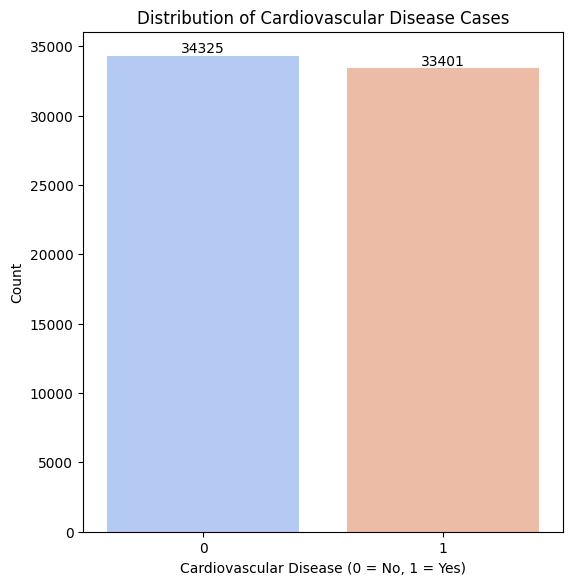

In [43]:
# Define parameters for plot
plot_params = {
    'data': df,
    'x': 'cardio',
    'palette': 'coolwarm',
    'figsize': (6, 4),
    'title': 'Distribution of Cardiovascular Disease Cases',
    'xlabel': 'Cardiovascular Disease (0 = No, 1 = Yes)',
    'ylabel': 'Count',
    'annotate': True,
    'annotation_format': '.0f',
    'annotation_offset': 5,
    'adjust_params': {'left': 0.15, 'right': 0.95, 'top': 1.4, 'bottom': 0.15}
}

# Create Count Plot with specified parameters
annotated_countplot(**plot_params)

SMOTE is not required here as the imbalance ratio being $( \frac{34,325}{33,401} \approx 1.028)$ illustrates negligible imbalance.


In [ ]:
# Define parameters for plot
plot_params = {

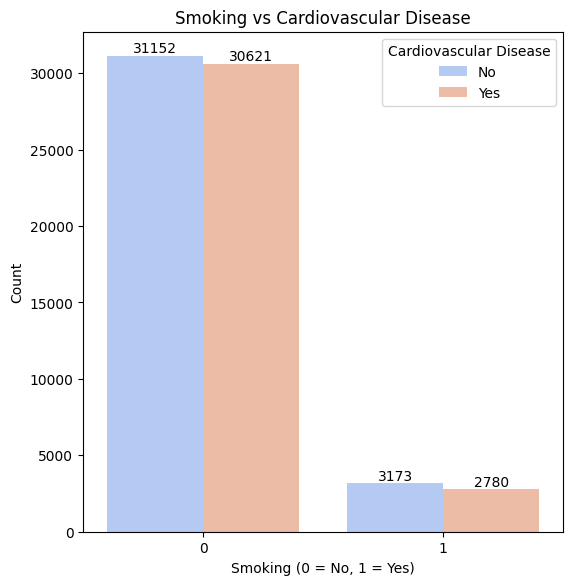

In [ ]:
    'data': df,
    'x': 'smoke',
    'hue': 'cardio',
    'palette': 'coolwarm',
    'figsize': (6, 4),
    'title': 'Smoking vs Cardiovascular Disease',
    'xlabel': 'Smoking (0 = No, 1 = Yes)',
    'ylabel': 'Count',
    'legend_labels': ['No', 'Yes'],
    'legend_title': 'Cardiovascular Disease',
    'annotate': True,
    'annotation_format': '.0f',
    'annotation_offset': 5,
    'adjust_params': {'left': 0.15, 'right': 0.95, 'top': 1.4, 'bottom': 0.15}
}

# Create Count Plot with specified parameters
annotated_countplot(**plot_params)

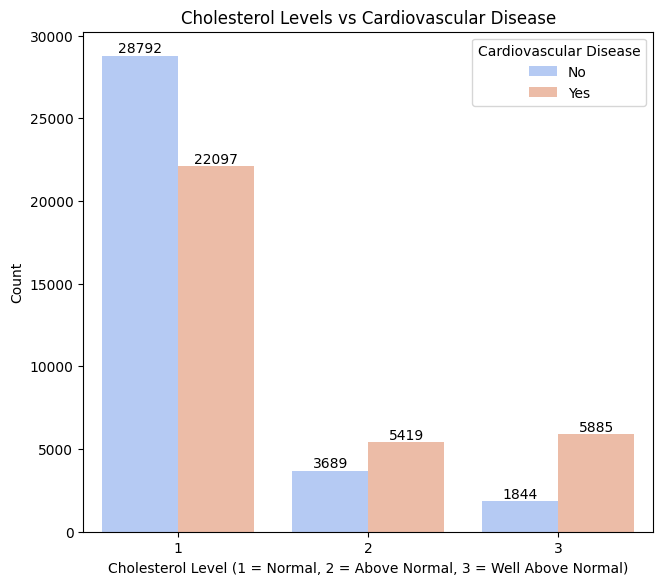

In [45]:
# Define parameters for plot
plot_params = {
    'data': df,
    'x': 'cholesterol',
    'hue': 'cardio',
    'palette': 'coolwarm',
    'figsize': (6, 4),
    'title': 'Cholesterol Levels vs Cardiovascular Disease',
    'xlabel': 'Cholesterol Level (1 = Normal, 2 = Above Normal, 3 = Well Above Normal)',
    'ylabel': 'Count',
    'legend_labels': ['No', 'Yes'],
    'legend_title': 'Cardiovascular Disease',
    'annotate': True,
    'annotation_format': '.0f',
    'annotation_offset': 5,
    'adjust_params': {'left': 0.15, 'right': 1.1, 'top': 1.4, 'bottom': 0.15}
}

# Create Count Plot with specified parameters
annotated_countplot(**plot_params)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


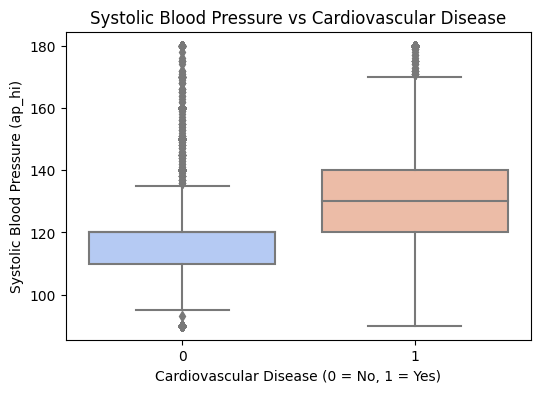

In [46]:
# Define parameters for plot
plot_params = {
    'data': df,
    'x': 'cardio',
    'y': 'ap_hi',
    'palette': 'coolwarm',
    'figsize': (6, 4),
    'title': 'Systolic Blood Pressure vs Cardiovascular Disease',
    'xlabel': 'Cardiovascular Disease (0 = No, 1 = Yes)',
    'ylabel': 'Systolic Blood Pressure (ap_hi)',
}

# Create Box Plot with specified parameters
create_boxplot(**plot_params)

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


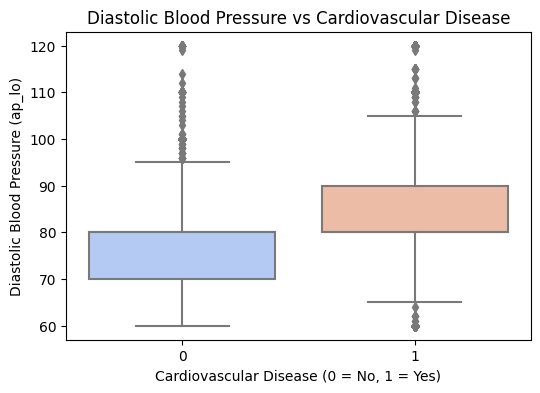

In [47]:
# Define parameters for plot
plot_params = {
    'data': df,
    'x': 'cardio',
    'y': 'ap_lo',
    'palette': 'coolwarm',
    'figsize': (6, 4),
    'title': 'Diastolic Blood Pressure vs Cardiovascular Disease',
    'xlabel': 'Cardiovascular Disease (0 = No, 1 = Yes)',
    'ylabel': 'Diastolic Blood Pressure (ap_lo)',
}

# Create Box Plot with specified parameters
create_boxplot(**plot_params)

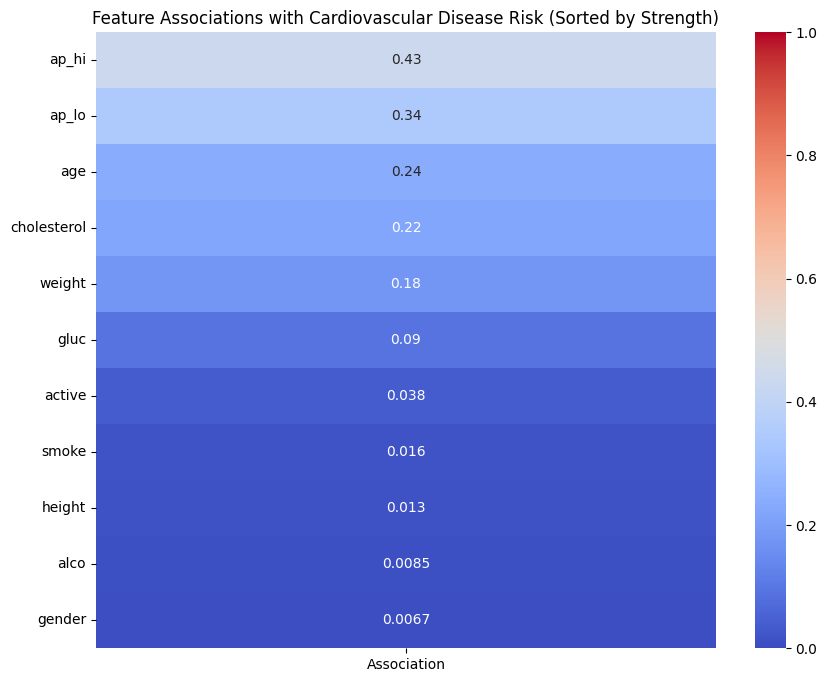

In [48]:
# Compute Associations for features with target
associations_df = compute_associations(df, 'cardio')

# Sort feature associations with target
sorted_associations_df = associations_df.sort_values(by='Association', ascending=False)

# Create Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_associations_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Feature Associations with Cardiovascular Disease Risk (Sorted by Strength)")
plt.show()

## Analysis of Heatmap: Cardiovascular Disease Risk Associations

This heatmap visualizes the strength of association between various features (patient case details) and cardiovascular disease risk level (`cardio`), represented by values ranging from 0 (no association to 1 (strong association).

### Key Observations

**Strongly Associated Features**

- Systolic Blood Pressure (`ap_hi`) (0.43): Strong association with cardiovascular disease, suggesting higher systolic blood pressure is an important risk factor

- Diastolic Blood Pressure (`ap_lo`) (0.34): Strong association, reinforcing the link between blood pressure and cardiovascular disease risk

**Moderately Associated Features**

- Age (`age`) (0.24): Significant risk factor

- Cholesterol Level Relative to Normal (`cholesterol`) (0.22): Higher cholesterol levels are linked to increased risk

- Weight (`weight`) (0.18): While less impactful than blood pressure or cholesterol, weight still contributes to the risk profile


**Weakly Associated Features:**

- Glucose Level Relative to Normal (`gluc`) (0.09): Low association

- Physical activity (`active`) (0.038): Unexpectedly low association

- Smoking (`smoke`) (0.016): Surprisingly minimal association possibly due to underreporting

- Height (`height`) (0.013): Feeble association

- Alcohol consumption (`alco`) (0.0085): Faint association

**Least Associated Feature:**

- Gender (`gender`) (0.0067): Negligible association

### Conclusion

- Blood pressure (both systolic and diastolic) is the most significant predictor of cardiovascular disease due to strong association.

- Age, cholesterol level, and weight, are moderately associated and should be considered for cardiovascular disease risk prediction.

- Glucose level, height, and lifestyle factors namely smoking, alcohol consumption, and physical activity show weaker associations.

- The negligible association with gender suggests that gender alone is not at all sufficient to determine cardiovascular disease risk

# Prepare Dataset for Tokenization

In [49]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [50]:
# Create list of dictionaries in which each dictionary represents one row of dataframe
patient_data_list = df.to_dict(orient='records')

# Open a json lines file in write mode
with open('patient_case_cvd_status.jsonl', 'w') as file:
    
    # Iterate over your list of patient data dictionaries
    for patient_data in patient_data_list:
    
        # Prepare the JSON object
        patient_case_cvd_status_json = prepare_patient_case_cvd_status_json(patient_data)
        
        # Serialize the JSON object to a string and write it to the json lines file
        file.write(patient_case_cvd_status_json + '\n')

In [51]:
# Display top 10 lines in json lines file
!head patient_case_cvd_status.jsonl

{"prompt": "A 50-year-old male with a height of 168 cm and weight of 62.0 kg has a systolic blood pressure of 110 mm Hg and diastolic blood pressure of 80 mm Hg. His cholesterol level is normal, and glucose is normal. He does not smoke, does not consume alcohol, and is physically active. What is the screening result for this patient's cardiovascular disease risk?", "response": "This patient's screening results indicate a low risk of cardiovascular disease."}
{"prompt": "A 55-year-old female with a height of 156 cm and weight of 85.0 kg has a systolic blood pressure of 140 mm Hg and diastolic blood pressure of 90 mm Hg. Her cholesterol level is well above normal, and glucose is normal. She does not smoke, does not consume alcohol, and is physically active. What is the screening result for this patient's cardiovascular disease risk?", "response": "This patient's screening results indicate an elevated risk of cardiovascular disease."}
{"prompt": "A 51-year-old female with a height of 165 

In [52]:
# Check number of lines in json lines file
!wc -l patient_case_cvd_status.jsonl

67726 patient_case_cvd_status.jsonl


In [53]:
# Load all the lines in json lines file
full_dataset = load_dataset('json', data_files='patient_case_cvd_status.jsonl')['train']
full_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['prompt', 'response'],
    num_rows: 67726
})

In [54]:
# Identify the unique classes in the 'response' column
class_names = full_dataset.unique('response')
print("Unique classes:", class_names)

Unique classes: ["This patient's screening results indicate a low risk of cardiovascular disease.", "This patient's screening results indicate an elevated risk of cardiovascular disease."]


In [55]:
# Create a ClassLabel feature
label_feature = ClassLabel(names=class_names)

# Convert the 'response' column to ClassLabel feature type
full_dataset = full_dataset.cast_column("response", label_feature)
print(full_dataset.features)

Casting the dataset:   0%|          | 0/67726 [00:00<?, ? examples/s]

{'prompt': Value(dtype='string', id=None), 'response': ClassLabel(names=["This patient's screening results indicate a low risk of cardiovascular disease.", "This patient's screening results indicate an elevated risk of cardiovascular disease."], id=None)}


In [56]:
print(label_feature)

ClassLabel(names=["This patient's screening results indicate a low risk of cardiovascular disease.", "This patient's screening results indicate an elevated risk of cardiovascular disease."], id=None)


In [57]:
# Check Target Distribution
analyze_risk_distribution(full_dataset)


Distribution in Full Dataset (before splitting):
- This patient's screening results indicate a low risk of cardiovascular disease.: 0.5068
- This patient's screening results indicate an elevated risk of cardiovascular disease.: 0.4932


In [58]:
# split the dataset with stratification on target
stratify_column = 'response'

# Split the dataset into train and test sets (90% train, 10% test) with shuffling and stratification
train_test_split = full_dataset.train_test_split(
    test_size=0.1,
    shuffle=True,
    seed=42,
    stratify_by_column=stratify_column
)

# Further split the test set into validation and test sets (50% validation, 50% test) with shuffling and stratification
test_valid_split = train_test_split['test'].train_test_split(
    test_size=0.5,
    shuffle=True,
    seed=42,
    stratify_by_column=stratify_column
)

# After both split operations, overall split (90% train, 5% test, 5% validation)

# Combine the splits into a DatasetDict
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'validation': test_valid_split['train'],
    'test': test_valid_split['test']
})

# Verify the splits
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response'],
        num_rows: 60953
    })
    validation: Dataset({
        features: ['prompt', 'response'],
        num_rows: 3386
    })
    test: Dataset({
        features: ['prompt', 'response'],
        num_rows: 3387
    })
})


In [59]:
# Verify Stratification
analyze_risk_distribution(dataset_dict['train'], 'train')
analyze_risk_distribution(dataset_dict['validation'], 'validation')
analyze_risk_distribution(dataset_dict['test'], 'test')


Distribution in train set:
- This patient's screening results indicate an elevated risk of cardiovascular disease.: 0.4932
- This patient's screening results indicate a low risk of cardiovascular disease.: 0.5068

Distribution in validation set:
- This patient's screening results indicate an elevated risk of cardiovascular disease.: 0.4932
- This patient's screening results indicate a low risk of cardiovascular disease.: 0.5068

Distribution in test set:
- This patient's screening results indicate a low risk of cardiovascular disease.: 0.5069
- This patient's screening results indicate an elevated risk of cardiovascular disease.: 0.4931


In [60]:
dataset_dict['train']['prompt'][0]

"A 50-year-old female with a height of 164 cm and weight of 52.0 kg has a systolic blood pressure of 130 mm Hg and diastolic blood pressure of 80 mm Hg. Her cholesterol level is normal, and glucose is normal. She does not smoke, does not consume alcohol, and is physically active. What is the screening result for this patient's cardiovascular disease risk?"

# Load Tokenizer and Model of T5

In [61]:
# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('google-t5/t5-small')

# Load the model
model = T5ForConditionalGeneration.from_pretrained('google-t5/t5-small')

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Perform Tokenization on Dataset Splits

In [62]:
# Tokenize all the splits
tokenized_datasets = dataset_dict.map(tokenize_patient_cases, batched=True)

# Verify the tokenized splits
print(tokenized_datasets)

Map:   0%|          | 0/60953 [00:00<?, ? examples/s]

Map:   0%|          | 0/3386 [00:00<?, ? examples/s]

Map:   0%|          | 0/3387 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['prompt', 'response', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 60953
    })
    validation: Dataset({
        features: ['prompt', 'response', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3386
    })
    test: Dataset({
        features: ['prompt', 'response', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3387
    })
})


In [63]:
tokenized_datasets['train']

Dataset({
    features: ['prompt', 'response', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 60953
})

In [64]:
len(tokenized_datasets['train'])

60953

In [65]:
tokenized_datasets['train']['prompt'][0:3]

["A 50-year-old female with a height of 164 cm and weight of 52.0 kg has a systolic blood pressure of 130 mm Hg and diastolic blood pressure of 80 mm Hg. Her cholesterol level is normal, and glucose is normal. She does not smoke, does not consume alcohol, and is physically active. What is the screening result for this patient's cardiovascular disease risk?",
 "A 64-year-old male with a height of 176 cm and weight of 74.0 kg has a systolic blood pressure of 140 mm Hg and diastolic blood pressure of 90 mm Hg. His cholesterol level is normal, and glucose is normal. He does not smoke, does not consume alcohol, and is physically active. What is the screening result for this patient's cardiovascular disease risk?",
 "A 58-year-old female with a height of 158 cm and weight of 90.0 kg has a systolic blood pressure of 140 mm Hg and diastolic blood pressure of 90 mm Hg. Her cholesterol level is normal, and glucose is well above normal. She does not smoke, does not consume alcohol, and is physica

In [66]:
tokenized_datasets['train']['response'][0:3]

[1, 1, 1]

# Fine-tune T5 on Training Dataset and Evaluate T5 on Validation Dataset

In [67]:
# Determine the device to use for training (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device (GPU or CPU)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [68]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./finetuning_checkpoints', # Directory to save checkpoints and logs
    run_name='t5_finetuning',              # Name of the training run (for logging)
    eval_strategy='epoch',                 # Evaluate at the end of each epoch
    learning_rate=2e-5,                    # Learning Rate for the optimizer
    per_device_train_batch_size=4,         # Batch size per GPU for training
    per_device_eval_batch_size=4,          # Batch size per GPU for evaluation
    weight_decay=0.01,                     # Weight decay for regularization
    save_total_limit=3,                    # Maximum number of checkpoints to save
    num_train_epochs=3,                    # Number of training epochs
    predict_with_generate=True,            # For generating prediction during evaluation
    disable_tqdm=False,                    # Enable built-in progress bar
    fp16=True,                             # Enable mixed-precision training (FP16)
    report_to='none',                      # Disable reporting to external services including Weights & Biases
    logging_steps=500,                     # Log metrics every 500 steps
    gradient_accumulation_steps=4,         # Accumulate gradients over 2 steps before updating weights
    dataloader_num_workers=4               # Number of subprocesses for data loading
)

# Handle batching and padding of data for training and evaluation
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,                                               # Fine-tuned model to be trained/evaluated
    args=training_args,                                        # Training hyperparameters
    train_dataset=tokenized_datasets['train'],                 # Training dataset (tokenized)
    eval_dataset=tokenized_datasets['validation'],             # Validation dataset (tokenized)
    processing_class=tokenizer,                                # Tokenizer used for processing the data
    data_collator=data_collator,                               # Data collator used for batching and padding
    compute_metrics=compute_exact_match_validation_accuracy    # Compute exact match validation accuracy
)

In [69]:
# Start fine-tuning
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Exact Match Validation Accuracy
1,0.001200,0.001088,0.735676
2,0.001200,0.001083,0.738334
3,0.001100,0.001083,0.737448


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.process


Exact Match Validation Accuracy computed in 120.98 seconds


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokeni


Exact Match Validation Accuracy computed in 127.36 seconds


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokeni


Exact Match Validation Accuracy computed in 120.28 seconds


TrainOutput(global_step=5715, training_loss=0.10779873800194274, metrics={'train_runtime': 10705.304, 'train_samples_per_second': 17.081, 'train_steps_per_second': 0.534, 'total_flos': 2.474846647536845e+16, 'train_loss': 0.10779873800194274, 'epoch': 3.0})

<b>Fine-tuning Model on Training Dataset and Evaluating Model on Validation Dataset</b> 
<ul>
<li>An epoch refers to one complete pass through the entire training dataset by model</li>
<li>Model is fine-tuned on entire training dataset during each epoch and evaluated on entire validation dataset at end of each epoch</li>
<li>5715 training steps (batches) are processed in each epoch (pass).</li>
<li>Since training runs for 3 epochs, the total number of batches processed across all epochs is 5715 X 3 = 17,145 batches</li>
</ul>



In [70]:
# Evaluate model on validation dataset
eval_results = trainer.evaluate()

# Print the evaluation results
print(f"Evaluation results: {eval_results}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


Exact Match Validation Accuracy computed in 121.16 seconds
Evaluation results: {'eval_loss': 0.0010834340937435627, 'eval_exact_match_validation_accuracy': 0.7374483165977554, 'eval_runtime': 299.4599, 'eval_samples_per_second': 11.307, 'eval_steps_per_second': 1.416, 'epoch': 3.0}


# Evaluate Fine-tuned T5 on Testing Dataset

In [71]:
# Generate predictions on testing dataset
predictions = trainer.predict(tokenized_datasets['test'])

# Decode predictions
decoded_predictions = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

# Decode true labels
decoded_labels = tokenizer.batch_decode(tokenized_datasets['test']['labels'], skip_special_tokens=True)

# Create reverse mapping of screening test responses
SCREENING_TEST_RESPONSES_REVERSED = create_reverse_mapping(SCREENING_TEST_RESPONSES)

# Map the decoded string labels and predictions to numerical labels and predictions
numerical_y_true = [SCREENING_TEST_RESPONSES_REVERSED.get(label, -1) for label in decoded_labels] # -1 for unknown
numerical_y_pred = [SCREENING_TEST_RESPONSES_REVERSED.get(prediction, -1) for prediction in decoded_predictions] # -1 for unknown

# Filter out unknown labels (-1) if any were encountered during mapping
valid_indices = [i for i, label in enumerate(numerical_y_true) if label != -1 and numerical_y_pred[i] != -1]
filtered_numerical_y_true = [numerical_y_true[i] for i in valid_indices]
filtered_numerical_y_pred = [numerical_y_pred[i] for i in valid_indices]

# Extract the string labels from the dictionary values
target_names = list(SCREENING_TEST_RESPONSES.values()) 

# Generate Classification Report
report = classification_report(
    filtered_numerical_y_true,
    filtered_numerical_y_pred,
    target_names=target_names,
    output_dict=False
)

print("Classification Report")
print(report)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr


Exact Match Validation Accuracy computed in 121.45 seconds
Classification Report
                                                                                       precision    recall  f1-score   support

      This patient's screening results indicate a low risk of cardiovascular disease.       0.71      0.78      0.75      1717
This patient's screening results indicate an elevated risk of cardiovascular disease.       0.75      0.67      0.71      1670

                                                                             accuracy                           0.73      3387
                                                                            macro avg       0.73      0.73      0.73      3387
                                                                         weighted avg       0.73      0.73      0.73      3387



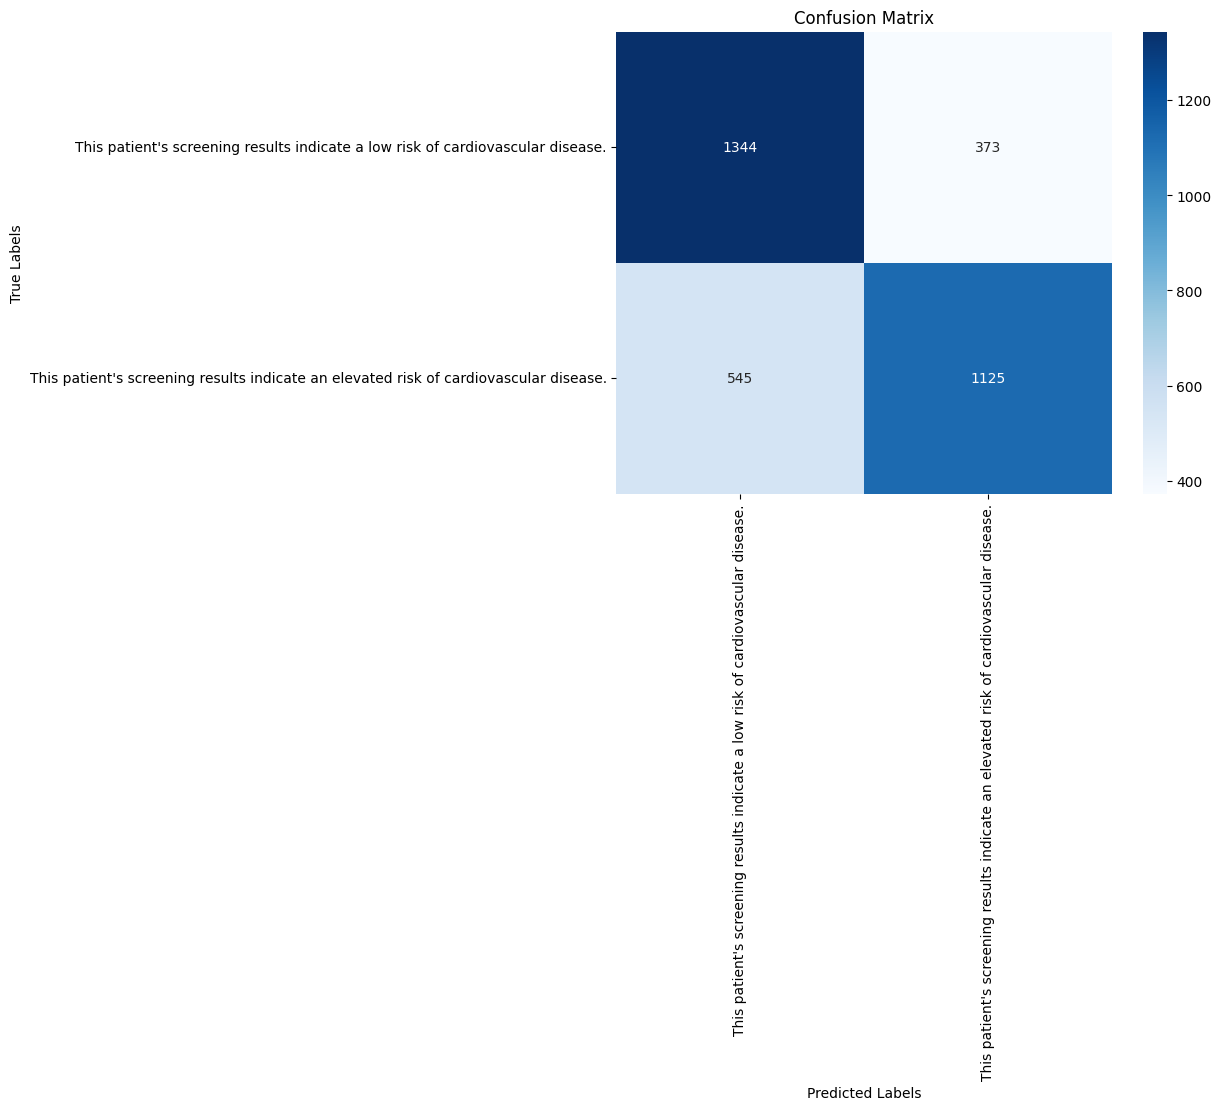

In [72]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(filtered_numerical_y_true, filtered_numerical_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', # 'fmt='d' for integer display
            xticklabels=target_names, yticklabels=target_names) # Use string labels for x and y ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')


plt.show() # Display the confusion matrix plot

# Save Fine-tuned and Evaluated T5

In [73]:
# Use the trainer to save the model
trainer.save_model("./fine_tuned")

In [74]:
# Create archive for fine_tuned directory
!tar cvf fine_tuned.tar fine_tuned

fine_tuned/
fine_tuned/training_args.bin
fine_tuned/generation_config.json
fine_tuned/added_tokens.json
fine_tuned/config.json
fine_tuned/special_tokens_map.json
fine_tuned/model.safetensors
fine_tuned/tokenizer_config.json
fine_tuned/spiece.model


# Generate Prediction from Saved Fine-tuned and Evaluated T5

In [75]:
# Determine the device to use for training (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device (GPU or CPU)
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [76]:
# Specify path to fine-tuned T5 in your local
model_path = "./fine_tuned"

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Load the model
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

# Set model to evaluation mode
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [77]:
# Get response from fine-tuned T5
screening_result_response = get_response('A 25-year-old male with a height of 178 cm and weight of 65.0 kg has a systolic blood pressure of 110 mm Hg and diastolic blood pressure of 80 mm Hg. His cholesterol level is normal, and glucose is normal. He does not smoke, does not consume alcohol, and is physically active.')
screening_result_response

"This patient's screening results indicate a low risk of cardiovascular disease."